# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

El propósito del proyecto es saber cuál de las dos tarifas genera más ingresos.
Lo primero que se realizará es la extracción y limpieza de datos, luego se necesitará unir tablas para calcular los ingresos que tendrán que ser graficados para ver su distribución, finalmente realizar la prueba de hipótesis correspondiente e interpretar resultados.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

users = pd.read_csv("/datasets/megaline_users.csv")
calls = pd.read_csv("/datasets/megaline_calls.csv")
messagues = pd.read_csv("/datasets/megaline_messages.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")


## Preparar los datos

### Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
print(plans.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [4]:
# Imprime una muestra de los datos para las tarifas

display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


#### Corregir datos

In [5]:
# cambiando tipo de dato

plans[["usd_monthly_pay","usd_per_gb"]] = plans[["usd_monthly_pay","usd_per_gb"]].astype(float)


#### Enriquecer los datos

In [6]:
# Agregando columna de gb_per_month

plans["gb_per_month"]= plans["mb_per_month_included"]/1024 # 1gb= 1025mb
print(plans.info())
display(plans)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
 8   gb_per_month           2 non-null      float64
dtypes: float64(5), int64(3), object(1)
memory usage: 272.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month
0,50,15360,500,20.0,10.0,0.03,0.03,surf,15.0
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,30.0


### Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
print(users.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [8]:
# Imprime una muestra de datos para usuarios
display(users.sample(5))


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
10,1010,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,NaN
261,1261,Dusti,Forbes,31,"Kansas City, MO-KS MSA",2018-02-22,surf,NaN
134,1134,Shannon,Nichols,71,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-09-03,surf,NaN
451,1451,Lenard,Harding,53,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-02-15,ultimate,2018-12-10
49,1049,Loise,Avery,25,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-21,surf,NaN


In [9]:
users["plan"].unique() # verificando valores único en plan

array(['ultimate', 'surf'], dtype=object)

In [10]:
users.duplicated().sum() # verificando filas duplicadas

0

In [11]:
users["user_id"].nunique() # verificando valores único en id

500

In [12]:
users[["first_name","last_name"]].duplicated().sum() # verificando nombres y apellidos únicos

0

In [13]:
display(sorted(users["city"].unique())) # verificando valores único en city


['Albany-Schenectady-Troy, NY MSA',
 'Albuquerque, NM MSA',
 'Atlanta-Sandy Springs-Roswell, GA MSA',
 'Austin-Round Rock-Georgetown, TX MSA',
 'Bakersfield, CA MSA',
 'Baltimore-Columbia-Towson, MD MSA',
 'Baton Rouge, LA MSA',
 'Birmingham-Hoover, AL MSA',
 'Boston-Cambridge-Newton, MA-NH MSA',
 'Bridgeport-Stamford-Norwalk, CT MSA',
 'Buffalo-Cheektowaga, NY MSA',
 'Cape Coral-Fort Myers, FL MSA',
 'Charleston-North Charleston, SC MSA',
 'Charlotte-Concord-Gastonia, NC-SC MSA',
 'Chicago-Naperville-Elgin, IL-IN-WI MSA',
 'Cincinnati, OH-KY-IN MSA',
 'Cleveland-Elyria, OH MSA',
 'Colorado Springs, CO MSA',
 'Columbia, SC MSA',
 'Columbus, OH MSA',
 'Dallas-Fort Worth-Arlington, TX MSA',
 'Dayton-Kettering, OH MSA',
 'Denver-Aurora-Lakewood, CO MSA',
 'Detroit-Warren-Dearborn, MI MSA',
 'El Paso, TX MSA',
 'Fresno, CA MSA',
 'Grand Rapids-Kentwood, MI MSA',
 'Greensboro-High Point, NC MSA',
 'Houston-The Woodlands-Sugar Land, TX MSA',
 'Indianapolis-Carmel-Anderson, IN MSA',
 'Jackson

In [14]:
users["age"].min()

18

La tabla muestra "churn_date" con solo 34 valores no nulos, lo que indica que de los 500 usuarios 34 ya se habían dado de baja.
Además "reg_date" no es datetime

Se verificó que no hay duplicados, que cada usuario tenga un plan consistente a los actuales y valores únicos en id.


#### Corregir los datos

Cambiar el tipo de dato a fecha

In [15]:
users["reg_date"]= pd.to_datetime(users["reg_date"])


#### Enriquecer los datos

In [16]:
users["reg_date"]= users["reg_date"].dt.strftime("%d/%m/%Y")

users["churn_date"].fillna("Vigente", inplace= True)

display(users.sample(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
34,1034,Jc,Gentry,22,"New York-Newark-Jersey City, NY-NJ-PA MSA",13/08/2018,surf,Vigente
288,1288,Jenette,Rush,60,"Las Vegas-Henderson-Paradise, NV MSA",18/07/2018,surf,Vigente
413,1413,Andre,Hensley,38,"Bakersfield, CA MSA",12/07/2018,surf,Vigente
57,1057,Theo,Sargent,18,"Atlanta-Sandy Springs-Roswell, GA MSA",07/08/2018,ultimate,Vigente
272,1272,Ernest,Mercado,23,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",04/08/2018,surf,Vigente
262,1262,Michelina,Hamilton,34,"Dallas-Fort Worth-Arlington, TX MSA",09/02/2018,surf,Vigente
283,1283,Alan,Burgess,38,"Charleston-North Charleston, SC MSA",16/06/2018,ultimate,Vigente
244,1244,Demarcus,Ellis,75,"Birmingham-Hoover, AL MSA",05/02/2018,surf,Vigente
324,1324,Romana,Moore,18,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",04/04/2018,surf,Vigente
99,1099,Shavon,Banks,48,"New York-Newark-Jersey City, NY-NJ-PA MSA",26/02/2018,surf,Vigente


### Llamadas

In [17]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
print(calls.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [18]:
# Imprime una muestra de datos para las llamadas
display(calls.sample(5))


,id,user_id,call_date,duration
59733,1215_118,1215,2018-11-05,16.24
13415,1057_294,1057,2018-10-11,19.66
41835,1153_683,1153,2018-11-20,3.42
30667,1114_623,1114,2018-08-30,0.24
66895,1240_753,1240,2018-06-29,0.00


In [19]:
#Verificando valores duplicados
calls.duplicated().sum()

0

In [20]:
#Verificando id unicos
calls["id"].nunique()

137735

Observaciones:
Call_date no es de tipo datetime, se debe cambiar el tipo de dato.
La duración en minutos no está redondeada, y debe ser tipo int, se podría crear una columna adicional con lo requerido.


#### Corregir los datos

In [21]:
calls["call_date"]= pd.to_datetime(calls["call_date"])

print(calls["call_date"])

0        2018-12-27
1        2018-12-27
2        2018-12-27
3        2018-12-28
4        2018-12-30
            ...    
137730   2018-11-21
137731   2018-10-20
137732   2018-09-21
137733   2018-10-10
137734   2018-12-29
Name: call_date, Length: 137735, dtype: datetime64[ns]


#### Enriquecer los datos

In [22]:
calls["month"]= calls["call_date"].dt.month # extrayendo mes
print(calls["month"])

0         12
1         12
2         12
3         12
4         12
          ..
137730    11
137731    10
137732     9
137733    10
137734    12
Name: month, Length: 137735, dtype: int64


In [23]:
calls["duration_min"]=np.ceil(calls["duration"]).astype(int)
print(calls["duration_min"])

0          9
1         14
2         15
3          6
4          5
          ..
137730     9
137731    11
137732     9
137733     1
137734    14
Name: duration_min, Length: 137735, dtype: int64


### Mensajes

In [24]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messagues.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [25]:
# Imprime una muestra de datos para los mensajes
messagues.sample(5)



,id,user_id,message_date
16860,1112_23,1112,2018-10-20
24602,1146_27,1146,2018-11-06
60153,1381_266,1381,2018-09-26
66118,1433_58,1433,2018-10-29
39878,1258_335,1258,2018-09-22


In [26]:
messagues.duplicated().sum() # revisando si hay filas duplicadas

0

In [27]:
messagues["id"].duplicated().sum() # revisando si id se repiten

0

El tipo de dato de "messague_date" debe ser  datetime.

#### Corregir los datos

In [28]:
messagues["message_date"]= pd.to_datetime(messagues["message_date"])



#### Enriquecer los datos

In [29]:
messagues["month"]= messagues["message_date"].dt.month # cambiando formato de fecha
print(messagues["month"])

0        12
1        12
2        12
3        12
4        12
         ..
76046    12
76047    12
76048    12
76049    12
76050    12
Name: month, Length: 76051, dtype: int64


### Internet

In [30]:
# Imprime la información general/resumida sobre el DataFrame de internet

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [31]:
# Imprime una muestra de datos para el tráfico de internet

internet.sample(5)

,id,user_id,session_date,mb_used
93345,1435_111,1435,2018-12-12,285.48
17824,1080_155,1080,2018-09-03,252.73
59620,1268_289,1268,2018-06-12,572.17
81090,1379_154,1379,2018-11-26,40.30
31446,1144_162,1144,2018-04-28,257.95


El tipo de dato de "session_date" debe ser datetime


#### Corregir los datos

In [32]:
internet["session_date"]= pd.to_datetime(internet["session_date"])

#### Enriquecer los datos

In [33]:
internet["month"]= internet["session_date"].dt.month

## Estudiar las condiciones de las tarifas

In [34]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month
0,50,15360,500,20.0,10.0,0.03,0.03,surf,15.0
1,1000,30720,3000,70.0,7.0,0.01,0.01,ultimate,30.0


## Agregar datos por usuario



In [35]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

calls_user_month = calls.groupby(["user_id","month"])["id"].count().reset_index()
display(calls_user_month)

,user_id,month,id
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [36]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

min_user_month = calls.groupby(["user_id","month"])["duration_min"].sum().reset_index()
prom_min = calls.groupby(["user_id","month"])["duration_min"].mean().reset_index()

display(min_user_month)
min_user_month["prom_duration_min"]=prom_min["duration_min"]


display(min_user_month)

,user_id,month,duration_min
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


,user_id,month,duration_min,prom_duration_min
0,1000,12,124,7.750000
1,1001,8,182,6.740741
2,1001,9,315,6.428571
3,1001,10,393,6.046154
4,1001,11,426,6.656250
...,...,...,...,...
2253,1498,12,339,8.692308
2254,1499,9,346,8.439024
2255,1499,10,385,7.264151
2256,1499,11,308,6.844444


In [37]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
message_user_month = messagues.groupby(["user_id","month"])["id"].count().reset_index()
display(message_user_month)


,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [38]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_user_month= internet.groupby(["user_id","month"])["mb_used"].sum().reset_index()
# Se agrega una columna ya redondeada

internet_user_month["gb_used"]= internet_user_month["mb_used"]/1024 # convirtiendo a gb
internet_user_month["gb_used"]= np.ceil(internet_user_month["gb_used"]).astype(int) # redondeando a más
display(internet_user_month)


,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19
...,...,...,...,...
2272,1498,12,23137.69,23
2273,1499,9,12984.76,13
2274,1499,10,19492.43,20
2275,1499,11,16813.83,17


In [39]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

consumo= pd.merge(calls_user_month , min_user_month,on=["user_id","month"],how="outer")
consumo= pd.merge(consumo , message_user_month,on=["user_id","month"],how="outer")
consumo= pd.merge(consumo , internet_user_month,on=["user_id","month"],how="outer")

#id_x= cantidad de llamadas
#id_y= cantidad de mensajes
consumo = consumo.drop("mb_used",axis=1)
display(consumo)

,user_id,month,id_x,duration_min,prom_duration_min,id_y,gb_used
0,1000,12,16.0,124.0,7.750000,11.0,2.0
1,1001,8,27.0,182.0,6.740741,30.0,7.0
2,1001,9,49.0,315.0,6.428571,44.0,14.0
3,1001,10,65.0,393.0,6.046154,53.0,22.0
4,1001,11,64.0,426.0,6.656250,36.0,19.0
...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,NaN,61.0,13.0
2289,1361,5,NaN,NaN,NaN,2.0,2.0
2290,1482,10,NaN,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,NaN,1.0


In [40]:
# Añade la información de la tarifa

consumo= pd.merge(consumo,users[["user_id","plan","city"]],on=["user_id"],how="left")

plans.rename(columns={'plan_name': 'plan'}, inplace=True)

consumo= pd.merge(consumo,plans,on=["plan"],how="left")

display(consumo)


,user_id,month,id_x,duration_min,prom_duration_min,id_y,gb_used,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month
0,1000,12,16.0,124.0,7.750000,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30.0
1,1001,8,27.0,182.0,6.740741,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
2,1001,9,49.0,315.0,6.428571,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
3,1001,10,65.0,393.0,6.046154,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
4,1001,11,64.0,426.0,6.656250,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,NaN,61.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
2289,1361,5,NaN,NaN,NaN,2.0,2.0,surf,"Birmingham-Hoover, AL MSA",50,15360,500,20.0,10.0,0.03,0.03,15.0
2290,1482,10,NaN,NaN,NaN,2.0,NaN,ultimate,"New York-Newark-Jersey City, NY-NJ-PA MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30.0
2291,1108,12,NaN,NaN,NaN,NaN,1.0,ultimate,"Salt Lake City, UT MSA",1000,30720,3000,70.0,7.0,0.01,0.01,30.0


In [41]:
print(type(consumo["duration_min"]))
consumo["duration_min"]=consumo["duration_min"].fillna(0) #cambiando valores nulos por 0
consumo["id_y"]=consumo["id_y"].fillna(0) #cambiando valores nulos por 0
consumo["gb_used"]=consumo["gb_used"].fillna(0) #cambiando valores nulos por 0
consumo.info()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   int64  
 2   id_x                   2258 non-null   float64
 3   duration_min           2293 non-null   float64
 4   prom_duration_min      2258 non-null   float64
 5   id_y                   2293 non-null   float64
 6   gb_used                2293 non-null   float64
 7   plan                   2293 non-null   object 
 8   city                   2293 non-null   object 
 9   messages_included      2293 non-null   int64  
 10  mb_per_month_included  2293 non-null   int64  
 11  minutes_included       2293 non-null   int64  
 12  usd_monthly_pay        2293 non-null   float64
 13  usd_per_gb             2293 non-null   float64
 14  usd_per_message     

In [42]:
# Calcula el ingreso mensual para cada usuario

def ingresos (consumo):
    if consumo["duration_min"]>consumo["minutes_included"]:
        consumo["llamadas"]=(consumo["duration_min"]-consumo["minutes_included"])*consumo["usd_per_minute"]
    else:
        consumo["llamadas"]=0
        
    if consumo["id_y"]>consumo["messages_included"]:
        consumo["mensajes"]=(consumo["id_y"]-consumo["messages_included"])*consumo["usd_per_message"]
    else:
        consumo["mensajes"]=0
        
    if consumo["gb_used"]>consumo["gb_per_month"]:
        consumo["internet"]=(consumo["gb_used"]-consumo["gb_per_month"])*consumo["usd_per_gb"]
    else:
        consumo["internet"]=0

    return consumo["llamadas"]+consumo["mensajes"]+consumo["internet"]


consumo["ingreso"]= consumo["usd_monthly_pay"] + consumo.apply(ingresos,axis=1)


In [43]:
display(consumo[["user_id","month","ingreso"]].sample(5))

,user_id,month,ingreso
2184,1483,10,20.00
1638,1361,9,40.00
1815,1399,6,30.00
1738,1383,10,70.00
395,1082,10,53.15


## Comportamiento de usuario

### Llamadas

In [44]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

dur_llamadas_promedio = pd.merge(calls,users,on=["user_id"],how="left")
display(dur_llamadas_promedio.info())
dur_llamadas_promedio =dur_llamadas_promedio.groupby(["plan","month"])["duration_min"].mean().reset_index()
display(dur_llamadas_promedio)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            137735 non-null  object        
 1   user_id       137735 non-null  int64         
 2   call_date     137735 non-null  datetime64[ns]
 3   duration      137735 non-null  float64       
 4   month         137735 non-null  int64         
 5   duration_min  137735 non-null  int64         
 6   first_name    137735 non-null  object        
 7   last_name     137735 non-null  object        
 8   age           137735 non-null  int64         
 9   city          137735 non-null  object        
 10  reg_date      137735 non-null  object        
 11  plan          137735 non-null  object        
 12  churn_date    137735 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 14.7+ MB


None

,plan,month,duration_min
0,surf,1,6.766667
1,surf,2,7.303279
2,surf,3,7.106742
3,surf,4,7.191899
4,surf,5,7.173700
5,surf,6,7.251863
6,surf,7,7.124836
7,surf,8,7.124718
8,surf,9,7.128537
9,surf,10,7.120604


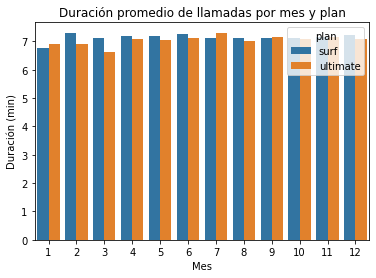

In [45]:
sns.barplot(x='month', y='duration_min', hue='plan', data=dur_llamadas_promedio)
# Añadir etiquetas y leyenda
plt.xlabel('Mes')
plt.ylabel('Duración (min)')
plt.title('Duración promedio de llamadas por mes y plan')

# Mostrar el gráfico
plt.show()

In [46]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

min_month = consumo.groupby(["plan","month","user_id"])["duration_min"].sum().reset_index()

display(min_month)

,plan,month,user_id,duration_min
0,surf,1,1042,114.0
1,surf,1,1362,292.0
2,surf,2,1042,254.0
3,surf,2,1099,39.0
4,surf,2,1138,307.0
...,...,...,...,...
2288,ultimate,12,1482,56.0
2289,ultimate,12,1487,416.0
2290,ultimate,12,1490,368.0
2291,ultimate,12,1493,473.0


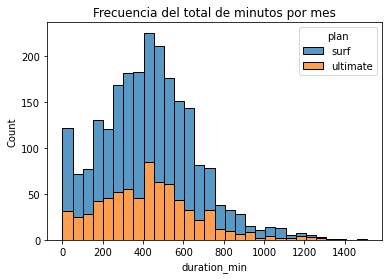

In [47]:
sns.histplot(data=min_month, x="duration_min", hue="plan", multiple="stack", bins=30, edgecolor='black')
# Añadir etiquetas y leyenda

plt.title('Frecuencia del total de minutos por mes')

# Mostrar el gráfico
plt.show()

In [48]:
# Calcula la media y la varianza de la duración mensual de llamadas.

min_month_surf = min_month[min_month["plan"]=="surf"]["duration_min"]
min_month_ultimate = min_month[min_month["plan"]=="ultimate"]["duration_min"]

media_surf = np.mean(min_month_surf)# calculando la media del plan surf
var_surf= np.var(min_month_surf)

media_ultimate =np.mean(min_month_ultimate) # calculando la media del plan surf
var_ultimate= np.var(min_month_ultimate)

print(f"La media de duración de llamadas mensuales del plan surf es de {media_surf} y la varianza es {var_surf}")
print(f"La media de duración de llamadas mensuales del plan ultimate es de {media_ultimate} y la varianza es {var_ultimate}")



La media de duración de llamadas mensuales del plan surf es de 428.7495232040687 y la varianza es 54933.33459131747
La media de duración de llamadas mensuales del plan ultimate es de 430.45 y la varianza es 57764.12527777777


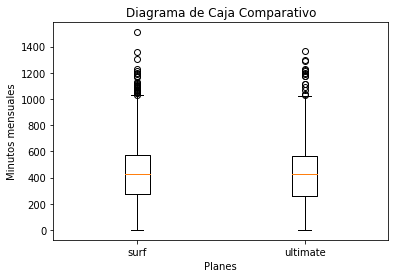

In [49]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

plt.boxplot([min_month_surf, min_month_ultimate], labels=['surf', 'ultimate'])
plt.xlabel('Planes')
plt.ylabel('Minutos mensuales')
plt.title('Diagrama de Caja Comparativo')
plt.show()

### Mensajes

In [50]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

cant_msj_month = consumo.groupby(["plan","month","user_id"])["id_y"].sum().reset_index()
display(cant_msj_month)

,plan,month,user_id,id_y
0,surf,1,1042,0.0
1,surf,1,1362,21.0
2,surf,2,1042,0.0
3,surf,2,1099,3.0
4,surf,2,1138,7.0
...,...,...,...,...
2288,ultimate,12,1482,5.0
2289,ultimate,12,1487,66.0
2290,ultimate,12,1490,0.0
2291,ultimate,12,1493,0.0


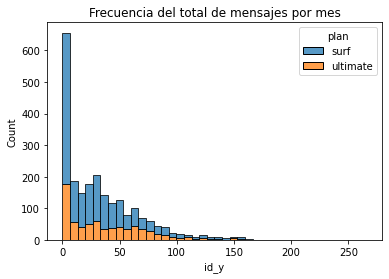

In [51]:
sns.histplot(data=cant_msj_month, x="id_y", hue="plan", multiple="stack", bins=40, edgecolor='black')
# Añadir etiquetas y leyenda

plt.title('Frecuencia del total de mensajes por mes')

# Mostrar el gráfico
plt.show()

Los usuarios del plan surf envían mensajes con más frecuencia

### Internet

In [52]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

gb_month_usu = consumo.groupby(["plan","month","user_id"])["gb_used"].sum().reset_index()
display(gb_month_usu)


,plan,month,user_id,gb_used
0,surf,1,1042,2.0
1,surf,1,1362,8.0
2,surf,2,1042,7.0
3,surf,2,1099,1.0
4,surf,2,1138,16.0
...,...,...,...,...
2288,ultimate,12,1482,1.0
2289,ultimate,12,1487,14.0
2290,ultimate,12,1490,46.0
2291,ultimate,12,1493,15.0


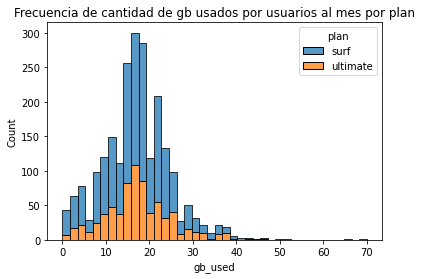

In [53]:
sns.histplot(data=gb_month_usu, x="gb_used", hue="plan", multiple="stack", bins=40, edgecolor='black')
# Añadir etiquetas y leyenda

plt.title('Frecuencia de cantidad de gb usados por usuarios al mes por plan')

# Mostrar el gráfico
plt.show()

In [54]:
# considerando consumo total por mes por plan

gb_month = consumo.groupby(["plan","month"])["gb_used"].sum().reset_index()
display(gb_month)

,plan,month,gb_used
0,surf,1,10.0
1,surf,2,110.0
2,surf,3,312.0
3,surf,4,611.0
4,surf,5,1087.0
5,surf,6,1502.0
6,surf,7,2042.0
7,surf,8,2735.0
8,surf,9,3238.0
9,surf,10,4126.0


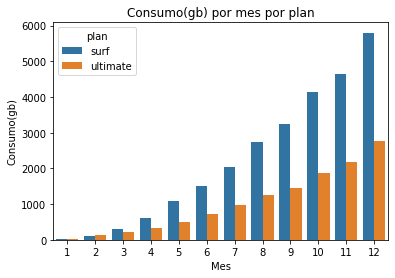

In [55]:
sns.barplot(x='month', y='gb_used', hue='plan', data=gb_month)
# Añadir etiquetas y leyenda
plt.xlabel('Mes')
plt.ylabel('Consumo(gb)')
plt.title('Consumo(gb) por mes por plan')

# Mostrar el gráfico
plt.show()

## Ingreso

In [56]:
# Compara la cantidad de ingresos por usuarios por plan al mes

ing_month_usu = consumo.groupby(["plan","month","user_id"])["ingreso"].sum().reset_index()
display(ing_month_usu)


,plan,month,user_id,ingreso
0,surf,1,1042,20.0
1,surf,1,1362,20.0
2,surf,2,1042,20.0
3,surf,2,1099,20.0
4,surf,2,1138,30.0
...,...,...,...,...
2288,ultimate,12,1482,70.0
2289,ultimate,12,1487,70.0
2290,ultimate,12,1490,182.0
2291,ultimate,12,1493,70.0


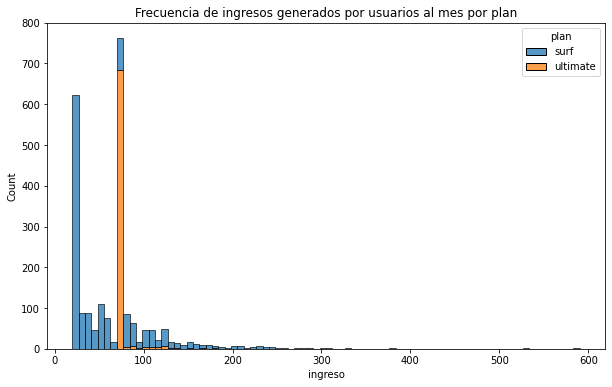

In [57]:
plt.figure(figsize=(10,6))
sns.histplot(data=ing_month_usu, x="ingreso", hue="plan", multiple="stack", bins=80, edgecolor='black')
# Añadir etiquetas y leyenda

plt.title('Frecuencia de ingresos generados por usuarios al mes por plan')

# Mostrar el gráfico
plt.show()

In [58]:
# considerando ingreso total por mes por plan

ing_month = consumo.groupby(["plan","month"])["ingreso"].sum().reset_index()
display(ing_month)

,plan,month,ingreso
0,surf,1,40.00
1,surf,2,309.57
2,surf,3,1056.65
3,surf,4,2035.53
4,surf,5,3667.37
5,surf,6,4779.80
6,surf,7,7583.56
7,surf,8,10356.85
8,surf,9,11304.67
9,surf,10,15504.83


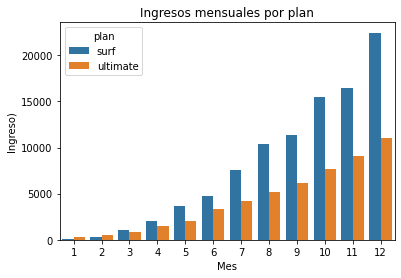

In [59]:
sns.barplot(x='month', y='ingreso', hue='plan', data=ing_month)
# Añadir etiquetas y leyenda
plt.xlabel('Mes')
plt.ylabel('Ingreso)')
plt.title('Ingresos mensuales por plan')

# Mostrar el gráfico
plt.show()

In [60]:
# Calcula la media y la varianza de los ingresos mensuales por usurio por mes.

ing_month_usu_surf = ing_month_usu [ing_month_usu ["plan"]=="surf"]["ingreso"]
ing_month_usu_ultimate = ing_month_usu [ing_month_usu["plan"]=="ultimate"]["ingreso"]

media_surf = np.mean(ing_month_usu_surf)# calculando la media del plan surf
var_surf= np.var(ing_month_usu_surf)

media_ultimate =np.mean(ing_month_usu_ultimate) # calculando la media del plan surf
var_ultimate= np.var(ing_month_usu_ultimate)

print(f"La media de ingresos mensuales por usuarios del plan surf es de {media_surf} y la varianza es {var_surf}")
print(f"La media de ingresos mensuales por usuarios del plan ultimate es de {media_ultimate} y la varianza es {var_ultimate}")

La media de ingresos mensuales por usuarios del plan surf es de 60.70640813731723 y la varianza es 3065.8848438690247
La media de ingresos mensuales por usuarios del plan ultimate es de 72.31388888888888 y la varianza es 129.66814043209877


los ingresos mensuales generados mediante el plan surf son mayores respecto al plan ultimate.
La media de los ingresos mensuales generados por usuarios del plan ultimate es mayor que el de surf.

## Prueba las hipótesis estadísticas

In [61]:
# Prueba las hipótesis
#Ho : El ingreso promedio procedente de un usuario del plan ultimate es igual al ingreso promedio procedente de un usuario del plan surf
#h1 : A <> B

ing_month_usu_surf # lista de ingresos por usuario por mes de surf
ing_month_usu_ultimate # lista de ingresos por usuario por mes de ultimate

alpha = 0.05

results =st.ttest_ind(ing_month_usu_surf, ing_month_usu_ultimate, equal_var= False)
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 3.1703905481136763e-15
Rechazamos la hipótesis nula


In [62]:
# Prueba las hipótesis

ingr_NYNJ = consumo[consumo["city"] =="New York-Newark-Jersey City, NY-NJ-PA MSA"]["ingreso"]
ingre_otras = consumo[consumo["city"]!="New York-Newark-Jersey City, NY-NJ-PA MSA"]["ingreso"]

media_NY = np.mean(ingr_NYNJ)# calculando la media del NY-NJ
var_NY= np.var(ingr_NYNJ)

media_otras =np.mean(ingre_otras) # calculando la media de otras regiones
var_otras= np.var(ingre_otras)

print(f"La media de ingresos mensuales de la region NY-NJ-PA MSA es de {media_NY} y la varianza es {var_NY}")
print(f"La media de ingresos mensuales de las otras regiones es de {media_otras} y la varianza es {var_otras}")


La media de ingresos mensuales de la region NY-NJ-PA MSA es de 59.921352785145885 y la varianza es 1890.5177172681156
La media de ingresos mensuales de las otras regiones es de 65.2227713987474 y la varianza es 2223.8866958162175


In [63]:
alpha = 0.05

results =st.ttest_ind(ingr_NYNJ, ingre_otras, equal_var= False)
print('valor p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p: 0.03352561588530014
Rechazamos la hipótesis nula


## Conclusión general

El objetivo del proyecto fue analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.
De la muestra se pudo observar lo siguiente:

La duración promedio de una llamada es alrededor de 7 min, y es similar en ambos planes
Los usuarios de plan surf envían más mensajes al mes que los usuarios del plan ultimate.
Considerando el consumo de gb de internet por usuario en cada mes, diferenciando el plan,  ambos tienen una distribución similar, sin embargo el plan surf tiene mayor frecuencia en los consumos y mayor consumo total por mes.
El comportamiento de un usuario en el consumos de minutos  por mes es similar en ambos planes. (llamadas)
Los ingresos mensuales totales generados mediante el plan surf son mayores respecto al plan ultimate.
Mediante la prueba de hipótesis realizada se concluye que hay evidencia para afirmar que las medias de los ingresos por mes de un usuario son diferentes.
Mediante la prueba de hipótesis realizada se concluye que hay evidencia para afirmar que las medias de los ingresos de la región NY-NJ-PA y el resto de regiones son diferentes.

Respecto a la limpieza y enrequecimiento de datos, se verificó valores nulos y duplicados,se cambió tipo de datos a datetime para que permitiera extraer el mes y agrupar correctamente la información, además se reviso y agrego  unidades para el cáculo de los ingresos, caso contrario el cálculo de ingresos podría variar.
Para la prueba de hipótesis se utilizó t student para comparar medias, y var= False ya que tenían varianzas diferentes.

Es importante conocer el comportamiento de cada usuario respecto a la necesidad de característica de cada plan, de esta forma ofrecerlo de tal forma que les favorezca.



<div class="alert alert-block alert-success">
    
# Comentarios generales
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
 Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>